[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1mUDx4uFpbS6jrD7lN-P7F7saefP_QJ31?usp=sharing)


In [ ]:
# Import required packages
!python -m spacy download fr_core_news_sm
#import fr_core_news_sm
import spacy
from spacy import displacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 

     |████████████████████████████████| 14.7 MB 4.6 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('fr_core_news_sm')


In [ ]:
# Import additional packages
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

import string
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
from spacy.lang.fr.stop_words import STOP_WORDS
from spacy.lang.fr.examples import sentences 
from spacy.lang.fr import French


In [ ]:
path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/training_data.csv"

df = pd.read_csv(path, index_col=0)
df.head()


,sentence,difficulty
id,,
0,Les coûts kilométriques réels peuvent diverger...,C1
1,"Le bleu, c'est ma couleur préférée mais je n'a...",A1
2,Le test de niveau en français est sur le site ...,A1
3,Est-ce que ton mari est aussi de Boston?,A1
4,"Dans les écoles de commerce, dans les couloirs...",B1


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 4800 entries, 0 to 4799
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   sentence    4800 non-null   object
 1   difficulty  4800 non-null   object
dtypes: object(2)
memory usage: 112.5+ KB


In [ ]:
# Base rate: the data-set is a bit balanced!
df.difficulty.value_counts()


A1    813
C2    807
C1    798
B1    795
A2    795
B2    792
Name: difficulty, dtype: int64

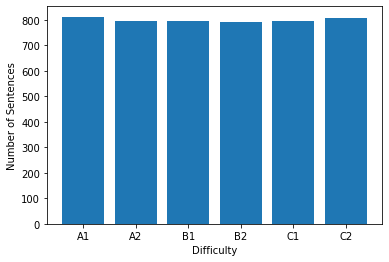

In [ ]:
difficulty_count = df.groupby("difficulty").count()
plt.bar(difficulty_count.index.values, difficulty_count["sentence"])
plt.xlabel("Difficulty")
plt.ylabel("Number of Sentences")
plt.show()

In [ ]:
round(df.difficulty.value_counts().max()/ len(df), 4)


0.1694

### tokening the date with spaCy


In [ ]:
# Create a list of punctuation marks
punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create a list of stopwords
#stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words = spacy.lang.fr.stop_words.STOP_WORDS

list(stop_words)[:10]

['doivent',
 'étaient',
 'ouf',
 'vont',
 'quels',
 'souvent',
 'sauf',
 'quant',
 'quatrièmement',
 'dit']

In [ ]:
# Load French language model
import fr_core_news_sm
#sp = spacy.load('en_core_web_sm')
sp = fr_core_news_sm.load()

# Create tokenizer function
def spacy_tokenizer(sentence):
    # Create token object, which is used to create documents with linguistic annotations.
    mytokens = sp(sentence)

    # Lemmatize each token and convert each token into lowercase
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    ## alternative way
    # mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Remove stop words and punctuation
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # Return preprocessed list of tokens
    return mytokens

texts = df['sentence']

# Tokenize texts
processed_texts = []
for text in texts:
  processed_text = spacy_tokenizer(text)
  processed_texts.append(processed_text)

In [ ]:
# Word embedding 
### Parameters: 
#     - min_count: minimum number of occurence of single word in corpus to be taken into account
#     - size: dimension of the vectors representing the tokens
#     - IMPORTANT: processed_texts must be a list of lists of tokens object!
from gensim.models import Word2Vec
word2vec = Word2Vec(processed_texts, min_count=2, size=100)
vocab = word2vec.wv.vocab

In [ ]:
# Example
#New_sentence = df["sentence"].sample()
New_sentence = df["sentence"].head()
New_sentence.values[0]
spacy_tokenizer(New_sentence.values[0])


['coût',
 'kilométrique',
 'réel',
 'pouvoir',
 'diverger',
 'sensiblemer',
 'valeur',
 'moyenner',
 'fonction',
 'moyen',
 'transport',
 'utiliser',
 'taux',
 'occupation',
 'taux',
 'remplissage',
 'infrastructure',
 'utiliser',
 'topographie',
 'ligne',
 'flux',
 'trafic',
 'etc.']

In [ ]:
#### **** ***************** **** ####
#### **** RAW TEXT FEATURES **** ####
#### **** ***************** **** ####

# Count tokens per sentence
def count_token(sent):
  return(len(spacy_tokenizer(sent))) #spacy_tokenizer() to get tokens, len() to count them

# Count raw words per sentence
def count_words(sent):
  return(len(sent.split())) #split() gives us individual words, len() counts them

#Get all characters in a sentece
def count_sentence_character(sent):
  words = sent.split()
  return(sum(len(word) for word in words))

#Get average character length of word
def count_avg_word_character(sent):
  words = sent.split()
  return(sum(len(word) for word in words) / len(words))

def count_avg_token_character(sent):
  words = spacy_tokenizer(sent)
  if len(words) == 0:
    return(0)
  else:
    return(sum(len(word) for word in words) / len(words))

#Get min character length of word
def count_min_word_character(sent):
  words = sent.split()
  return(min(len(word) for word in words))

#Get max character length of word
def count_max_word_character(sent):
  words = sent.split()
  return(max(len(word) for word in words))

In [ ]:
#### **** **************** **** ####
#### **** LEXICAL FEATURES **** ####
#### **** **************** **** ####

# Lexical Diversity
def lex_div_word(sent):
  total_number_word = len(sent.split())
  unique = set(sent.split())
  return(len(unique)/total_number_word)
#We don't apply for token, as the goal of the tokenzization is to be left with 
#unique tokens
#For tokens, we should apply to the whole text as done by tfidf_vector

# Lexical Density
def lex_den_tokens(sent):
  st = spacy_tokenizer(sent)
  if len(st) == 0:
    return(0)
  else:
    string = " ".join([str(item) for item in st])
    x = sp(string)
    counter = 0 
    for token in x:
      if token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB" or token.pos_ == "ADV":
        counter = counter + 1
    return(counter/len(st))

def lex_den_words(sent):
  x = sp(sent)
  counter = 0 
  for token in x:
    if token.pos_ == "NOUN" or token.pos_ == "ADJ" or token.pos_ == "VERB" or token.pos_ == "ADV":
      counter = counter + 1
  return(counter/len(x))

# Words NOT in frequent list
path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/list_words.csv"
words = pd.read_csv(path, index_col=0)


def words_list(sent):
  unique = set(sent.split())
  counter = 0
  for word_in_sentence in unique:
    for word_in_list in words.Mots:
      if word_in_sentence == word_in_list:
        counter = counter + 1
        break#we stop comparing once the word in found, to make it faster
  return(1-(counter/len(unique)))


def token_list(sent):
  unique = spacy_tokenizer(sent)
  if len(unique) == 0:
    return(0)
  else:
    counter = 0
    for word_in_sentence in unique:
      for word_in_list in words.Mots:
        if word_in_sentence == word_in_list:
          counter = counter + 1
          break#we stop comparing once the word in found, to make it faster
    return(1-(counter/len(unique)))

#Word Embedding:
def get_vector(sent):
  token = spacy_tokenizer(sent)
  for word in token: 
    if word in word2vec.wv.vocab:
      return(np.mean(word2vec[word]))

In [ ]:
def get_features(data_to_process):
  raw_word_count = pd.Series(data_to_process.sentence.apply(count_words),name="raw_word_count")
  token_count = pd.Series(data_to_process.sentence.apply(count_token),name="token_count")
  avg_chr_word = pd.Series(data_to_process.sentence.apply(count_avg_word_character),name="avg_chr_word")
  min_chr_word = pd.Series(data_to_process.sentence.apply(count_min_word_character),name="min_chr_word")
  max_chr_word = pd.Series(data_to_process.sentence.apply(count_max_word_character),name="max_chr_word")
  tot_chr_stn = pd.Series(data_to_process.sentence.apply(count_sentence_character),name="tot_chr_stn") 
  avg_chr_token = pd.Series(data_to_process.sentence.apply(count_avg_token_character),name="avg_chr_token")
  diversity_word = pd.Series(data_to_process.sentence.apply(lex_div_word),name="diversity_word")
  density_word = pd.Series(data_to_process.sentence.apply(lex_den_words),name="density_word")
  density_token = pd.Series(data_to_process.sentence.apply(lex_den_tokens),name="density_token")
  freq_word_list = pd.Series(data_to_process.sentence.apply(words_list),name="freq_word_list")
  freq_token_list = pd.Series(data_to_process.sentence.apply(token_list),name="freq_token_list")
  token_wv = pd.Series(data_to_process.sentence.apply(get_vector),name="token_wv")
  
  processed_df = pd.concat([data_to_process,raw_word_count,token_count,avg_chr_word,min_chr_word,max_chr_word,tot_chr_stn,avg_chr_token,
                    diversity_word,density_word,density_token,freq_word_list,freq_token_list,token_wv],axis=1)
  return(processed_df)

def scale_data(df_to_scale):
  scaler = MinMaxScaler()
  col_to_scale = ["raw_word_count","token_count","avg_chr_word","min_chr_word","max_chr_word","tot_chr_stn","avg_chr_token",]
  #no need for the others because they already are on a scale from 0 to 1
  df_to_scale[col_to_scale]= scaler.fit_transform(df_to_scale[col_to_scale])
  return(df_to_scale) 


In [ ]:
new_df = get_features(df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
new_df = scale_data(new_df)
new_df["token_wv"] = new_df["token_wv"].fillna(0)
new_df.token_wv.isna().sum()

0

## classification of level using logistic regression

In [ ]:
# Select features
X = new_df[["sentence","raw_word_count","token_count","avg_chr_word","min_chr_word","max_chr_word","tot_chr_stn","avg_chr_token",
                    "diversity_word","density_word","density_token","freq_word_list",
            "freq_token_list","token_wv"]]# the features we want to analyze

ylabels = new_df['difficulty'] # the labels, or answers, we want to test against

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=1234, stratify=ylabels)

X_train

,sentence,raw_word_count,token_count,avg_chr_word,min_chr_word,max_chr_word,tot_chr_stn,avg_chr_token,diversity_word,density_word,density_token,freq_word_list,freq_token_list,token_wv
id,,,,,,,,,,,,,,
962,Le réalisateur m'a d'abord demandé de me mettr...,0.037879,0.032,0.272727,0.083333,0.333333,0.039110,0.645833,1.000000,0.428571,1.000000,0.545455,0.500000,0.000499
1886,"Après quelques mois de cette pauvreté noble, a...",0.109848,0.112,0.266667,0.083333,0.375000,0.110429,0.517857,0.966667,0.352941,0.714286,0.586207,0.714286,0.000026
2721,L'indicateur n'était que de 40% chez les femme...,0.034091,0.040,0.245455,0.083333,0.375000,0.032975,0.483333,1.000000,0.357143,0.600000,0.600000,0.800000,-0.000402
1025,L'objectif de ce type de voyage est d'être act...,0.094697,0.096,0.241259,0.083333,0.291667,0.089724,0.527778,0.923077,0.482759,1.000000,0.375000,0.416667,0.000408
4048,"Et, en France, beaucoup moins de filles que de...",0.083333,0.080,0.276680,0.000000,0.458333,0.085890,0.500000,0.956522,0.384615,0.500000,0.636364,0.300000,-0.000965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3693,Je vais prendre ma douche dans ma salle-de-bain.,0.026515,0.032,0.284091,0.083333,0.458333,0.028374,0.645833,0.875000,0.333333,0.750000,0.714286,0.500000,-0.001026
3408,"Après l'éruption de 1754, la plus grosse connu...",0.132576,0.128,0.275253,0.000000,0.375000,0.135736,0.546875,0.805556,0.380952,0.625000,0.655172,0.625000,-0.000191
4289,Léonard est initié par Verrocchio aux nombreus...,0.117424,0.120,0.369318,0.083333,0.458333,0.145706,0.644444,0.937500,0.472222,0.866667,0.666667,0.866667,0.000332


In [ ]:
y_train


id
962     B1
1886    C1
2721    A2
1025    B1
4048    B2
        ..
3693    A1
3408    B1
4289    C2
3312    C2
269     A1
Name: difficulty, Length: 3840, dtype: object

In [ ]:
# Evaluate the model
def evaluate(test, pred):
  precision = precision_score(test, pred,average=None)
  recall = recall_score(test, pred, average=None)
  f1= f1_score(test, pred, average=None)
  print(f'CONFUSION MATRIX:\n{confusion_matrix(test, pred)}')
  print(f"ACCURACY SCORE:\n{accuracy_score(test, pred) :.4f}")
  print(f'CLASSIFICATION REPORT:')
  print("Precision:\t {0:4f}".format(precision_score(test, pred,average="macro"))) 
  print("Recall:\t {0:4f}".format(recall_score(test, pred, average="macro")))
  print("F1_Score:\t {0:4f}".format(f1_score(test, pred, average="macro")))


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report


# Define classifier
classifier = LogisticRegression(multi_class="multinomial",max_iter=1000)

#Vectorizer
tfidf_vector = TfidfVectorizer(tokenizer=spacy_tokenizer)

#Column Transformer (to apply vectorizer to the right column)
column_transformer = ColumnTransformer(
    [("tfidf", tfidf_vector, "sentence")],
    remainder="passthrough")

# Create pipeline
pipe = Pipeline([("tfidf",column_transformer),("classifier", classifier)])

# Fit model on training set
pipe.fit(X_train, y_train)
# Predictions
y_pred = pipe.predict(X_test)

# Evaluation - test set
evaluate(y_test, y_pred)


#nominmax to word2vec: 0.4833

CONFUSION MATRIX:
[[101  27  24  10   1   0]
 [ 47  63  37   7   5   0]
 [ 23  39  68  19   5   5]
 [  5   7  16  69  31  30]
 [  4   3  13  35  74  31]
 [  5   1  10  25  31  89]]
ACCURACY SCORE:
0.4833
CLASSIFICATION REPORT:
Precision:	 0.482747
Recall:	 0.482589
F1_Score:	 0.481731


In [ ]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
#Create a Gaussian Classifier
random_for=RandomForestClassifier(n_estimators=100)

pipe_rf = Pipeline([("tfidf",column_transformer),('feature_selection',SelectFromModel(LinearSVC(penalty="l2"))),("model", random_for)])
#Train the model using the training sets y_pred=clf.predict(X_test)
pipe_rf.fit(X_train,y_train)

y_pred=pipe_rf.predict(X_test)
evaluate(y_test, y_pred)


#nominmax to word2vec: 0.4625

CONFUSION MATRIX:
[[119  26  16   2   0   0]
 [ 49  68  38   4   0   0]
 [ 20  44  64  15   9   7]
 [  9   3  26  64  33  23]
 [  9   3  15  38  64  31]
 [  1   4  11  28  52  65]]
ACCURACY SCORE:
0.4625
CLASSIFICATION REPORT:
Precision:	 0.459264
Recall:	 0.461507
F1_Score:	 0.457502


In [ ]:
from sklearn.svm import LinearSVC


#Train the model
lsvc = LinearSVC(verbose=0)

pipe_lsvc = Pipeline([("tfidf",column_transformer),("model", lsvc)])
pipe_lsvc.fit(X_train,y_train)
y_pred=pipe_lsvc.predict(X_test)
evaluate(y_test, y_pred)

#nominmax to word2vec: 0.4594

CONFUSION MATRIX:
[[104  31  21   5   1   1]
 [ 48  56  43   6   6   0]
 [ 29  42  54  17  10   7]
 [  7  12  17  66  26  30]
 [  5   5   8  31  77  34]
 [  5   2  12  24  34  84]]
ACCURACY SCORE:
0.4594
CLASSIFICATION REPORT:
Precision:	 0.455572
Recall:	 0.458429
F1_Score:	 0.455888


In [ ]:
### Submission data

path = "https://raw.githubusercontent.com/Lirette2/DMML2021_Apple/main/data/unlabelled_test_data.csv"
sub_df = pd.read_csv(path, index_col=0)

new_sub_df = get_features(sub_df)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:70: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


In [ ]:
new_sub_df = scale_data(new_sub_df)
new_sub_df["token_wv"] = new_sub_df["token_wv"].fillna(0)
#new_sub_df.token_wv.isna().sum()

In [ ]:
# Get it in correct form and predict
X_sub = new_sub_df[["sentence","raw_word_count","token_count","avg_chr_word","min_chr_word","max_chr_word","tot_chr_stn","avg_chr_token",
                    "diversity_word","density_word","density_token","freq_word_list",
            "freq_token_list","token_wv"]]

y_sub = pipe_lsvc.predict(X_sub)


In [ ]:
new_sub_df["difficulty"] = y_sub
submission = new_sub_df.filter(["id","difficulty"],axis=1)
submission

,difficulty
id,
0,C1
1,B1
2,C1
3,C1
4,C2
...,...
1195,C2
1196,A2
1197,C2


In [ ]:
from google.colab import files
submission.to_csv('submission_11_apple_unil.csv') 
files.download('submission_11_apple_unil.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>